In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
from torch.nn.modules.dropout import Dropout2d
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
%matplotlib inline

In [3]:
# Simplenet 모델 정의
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(512, 2048, 1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),

            nn.Conv2d(2048, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 256, 3,padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
# 클래스 레이블
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 데이터 증강 설정
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2)
])

# 테스트 데이터는 증강하지 않음
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset_size = len(trainset)
testset_size = len(testset)
trainset_size, testset_size

(50000, 10000)

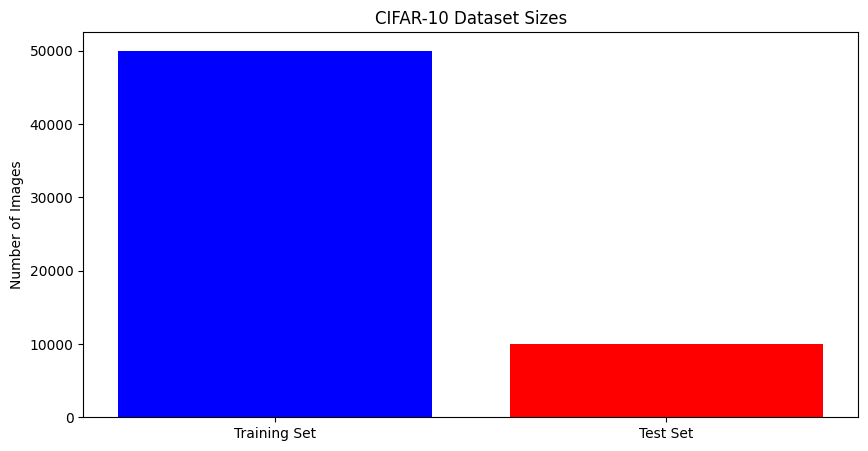

In [6]:
import matplotlib.pyplot as plt

# 데이터셋 크기를 저장할 리스트
dataset_sizes = [trainset_size, testset_size]
dataset_names = ["Training Set", "Test Set"]

plt.figure(figsize=(10, 5))
plt.bar(dataset_names, dataset_sizes, color=['blue', 'red'])
plt.title("CIFAR-10 Dataset Sizes")
plt.ylabel("Number of Images")
plt.show()

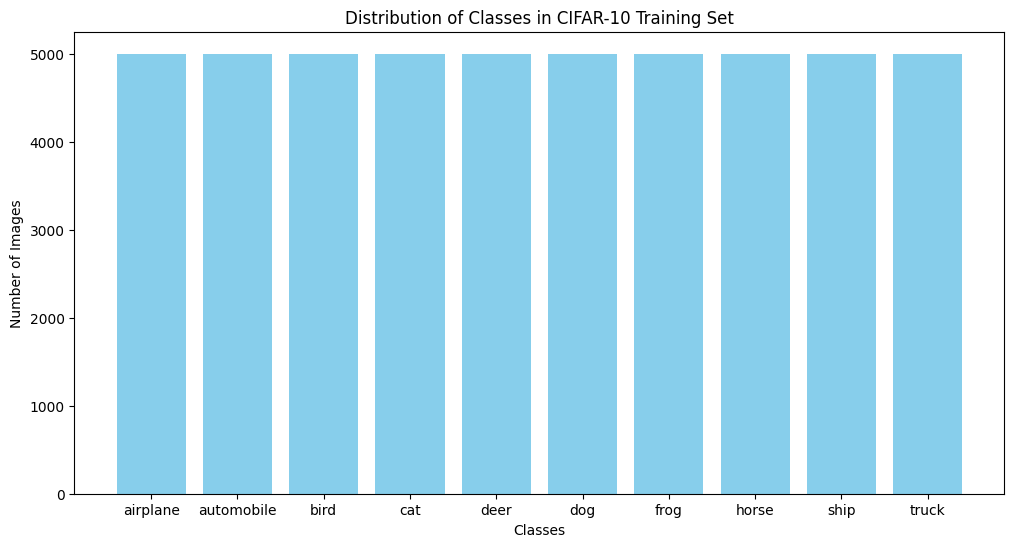

In [7]:
# 각 클래스의 샘플 수를 카운트
class_counts = np.zeros(10)
for _, label in trainset:
    class_counts[label] += 1

# 바 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in CIFAR-10 Training Set')
plt.show()

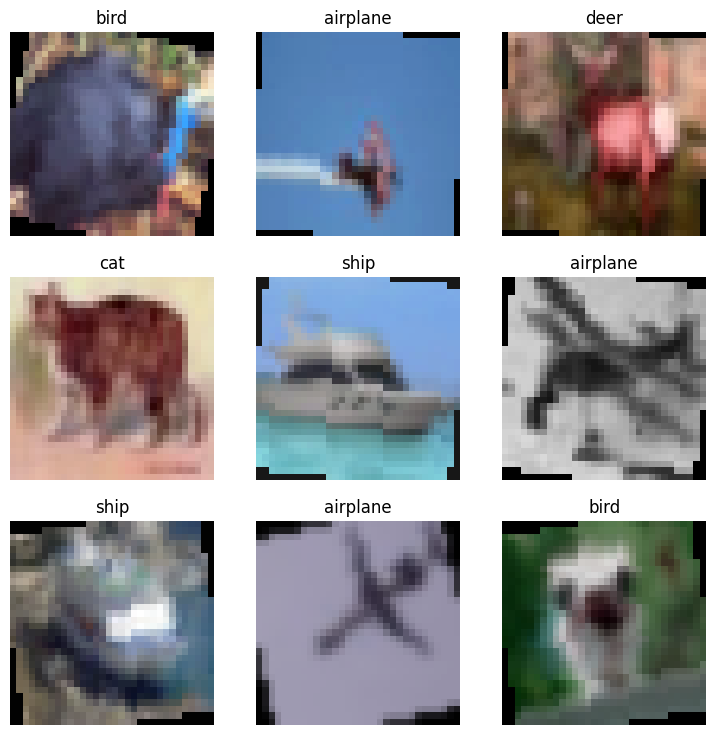

In [8]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 데이터 로더에서 하나의 배치를 불러오기 위해 for 루프 사용
for images, labels in trainloader:
    break  # 하나의 배치만 필요하므로 루프를 즉시 중단

# 이미지와 레이블을 3x3 그리드로 표시
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    ax.set_title(classes[labels[i]])
plt.show()

In [9]:
# Xavier         
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델, 손실 함수, 옵티마이저
model = SimpleNet()
model.apply(init_weights)
model = model.to("cuda")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=0.001, weight_decay=0.002)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0
num_epoch = 150

# Train
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train
    for step, batch in enumerate(trainloader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(trainloader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
            
    correct = 0
    total_cnt = 0


C:\Users\james\AppData\Local\Temp\ipykernel_24112\1630660636.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


====== 1 epoch of 150 ======

====== 100 Step of 782 ======
Train Acc : 0.2568069306930693
Train Loss : 0.030524026602506638

====== 200 Step of 782 ======
Train Acc : 0.29578669154228854
Train Loss : 0.027098534628748894

====== 300 Step of 782 ======
Train Acc : 0.32537375415282394
Train Loss : 0.026172352954745293

====== 400 Step of 782 ======
Train Acc : 0.3480361596009975
Train Loss : 0.023599516600370407

====== 500 Step of 782 ======
Train Acc : 0.3696981037924152
Train Loss : 0.02161867916584015

====== 600 Step of 782 ======
Train Acc : 0.3854773294509151
Train Loss : 0.019077666103839874

====== 700 Step of 782 ======
Train Acc : 0.40228245363766046
Train Loss : 0.018880877643823624
====== 2 epoch of 150 ======

====== 100 Step of 782 ======
Train Acc : 0.5292388613861386
Train Loss : 0.019919030368328094

====== 200 Step of 782 ======
Train Acc : 0.5457089552238806
Train Loss : 0.020154908299446106

====== 300 Step of 782 ======
Train Acc : 0.5517545681063123
Train Loss : 0

#### optimizer로 Adadelta 사용

In [73]:
def plot_train_graph(train_losses, train_accuracies):
    epochs = range(len(train_losses))
    
    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy over Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


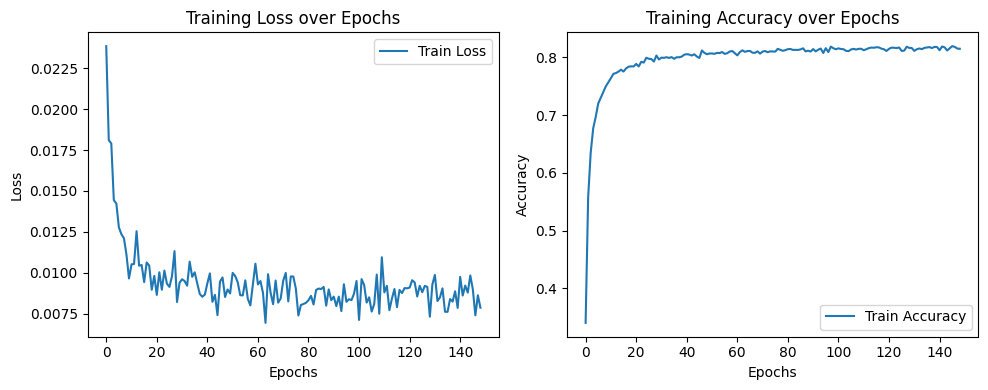

In [74]:
# Now, let's plot the graphs for the averaged train accuracy and train loss over epochs
plot_train_graph(avg_train_loss_list, avg_train_acc_list)


In [22]:
# Initialize variables
best_acc = 0.0
total_cnt = 0
valid_loss = 0.0
correct = 0

# Assume loss_fn and model are already defined and on the same device
# loss_fn = ...
# model = ...

model_name = 'DLthonsimplenet.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    model.eval()
    for step, batch in enumerate(testloader):
        # input and target
        inputs, labels = batch[0].to(device), batch[1].to(device)
        total_cnt += labels.size(0)
        
        logits = model(inputs)
        batch_loss = loss_fn(logits, labels)
        valid_loss += batch_loss.item() * labels.size(0)
        
        _, predict = logits.max(1)
        correct += predict.eq(labels).sum().item()
        
    valid_acc = correct / total_cnt
    avg_valid_loss = valid_loss / total_cnt
    
    print(f"\ntest Acc : {valid_acc}")
    print(f"test Loss : {avg_valid_loss}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_name)
        print("Model Saved!")



test Acc : 0.8291
test Loss : 0.516137908744812
Model Saved!


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_saved_model_on_test(model_path, testloader):
    # Initialize the model first (replace YourModelArchitecture with your model's class)
    loaded_model = SimpleNet()
    
    # Load the state_dict into the model
    loaded_model.load_state_dict(torch.load(model_path))
    
    # Move model to device
    loaded_model = loaded_model.to(device)
    
    total_cnt = 0
    correct = 0
    test_loss = 0.0

    # 모델을  평가 모드로 설정
    loaded_model.eval()
    

    loss_fn = torch.nn.CrossEntropyLoss()

    # 배치단위로 데이터 가져옴
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(device), batch[1].to(device)
        
            logits = loaded_model(images)
            
    
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            
    
            _, predicted = logits.max(1)
            total_cnt += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    
    test_acc = correct / total_cnt
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Loss: {test_loss / total_cnt:.4f}")

evaluate_saved_model_on_test('DLthonsimplenet.pth', testloader)

Test Accuracy: 82.91%
Test Loss: 0.0081


- 4시간 소요
- 각클래스 별 분류 성능을 확인하기 위해 confusion matrix 사용

C:\Users\james\AppData\Local\Temp\ipykernel_24112\3198826075.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):


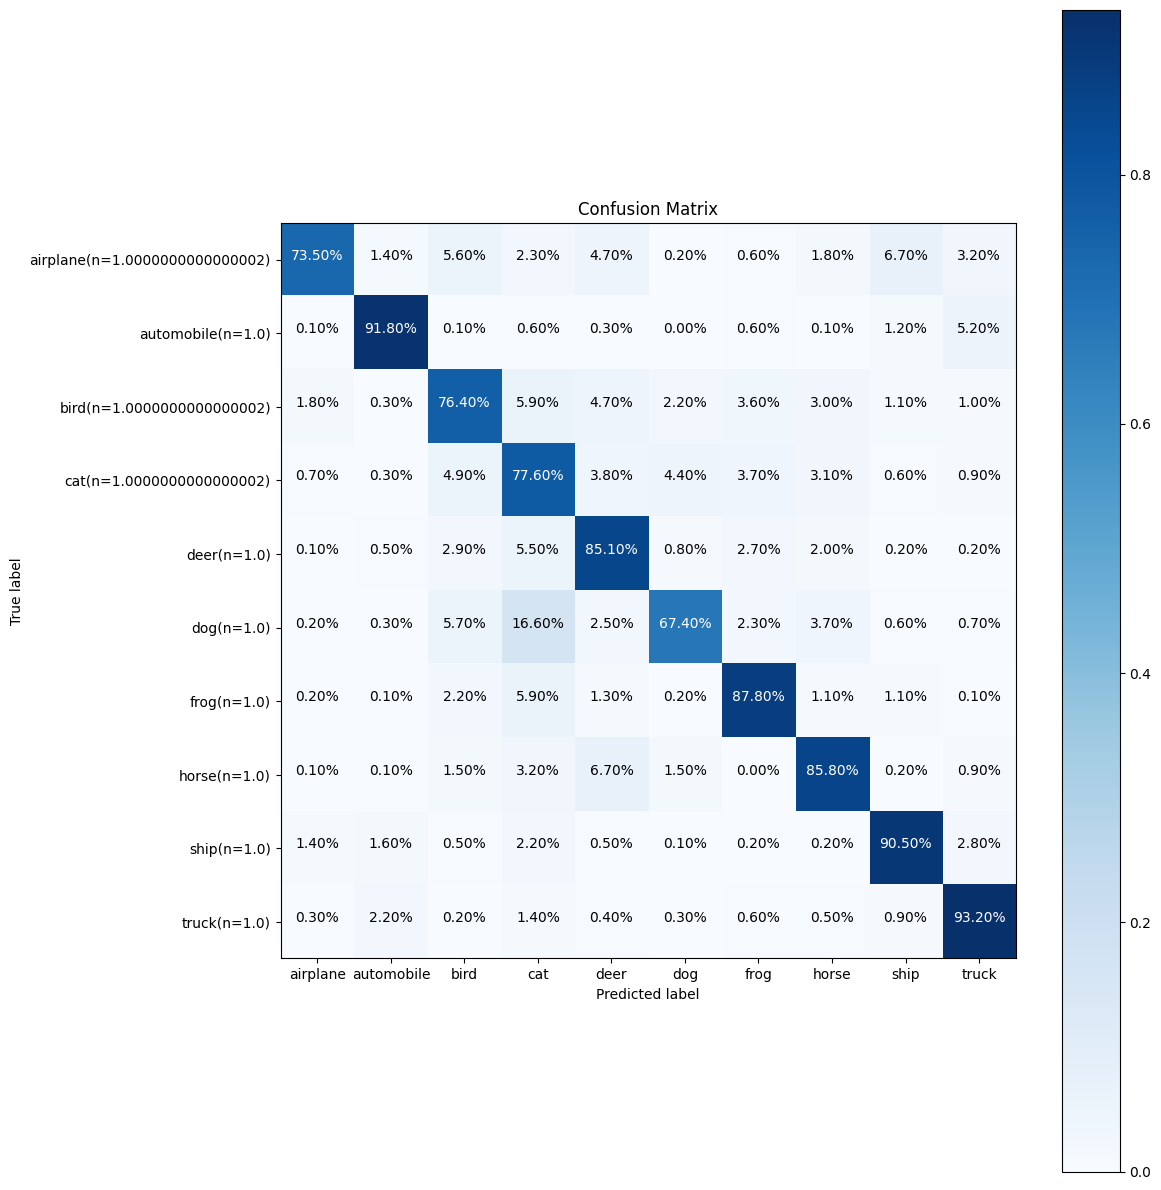

In [36]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터셋에 대한 성능을 평가하기 위한 변수 초기화
test_loss = 0.0
test_corrects = 0

# Confusion matrix를 위한 레이블과 예측값을 저장할 리스트
true_labels = []
pred_labels = []

# GPU 설정 (이미 설정되어 있다면 생략 가능)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in testloader:
        # 데이터를 GPU로 옮김 (이미 옮겨져 있다면 생략 가능)
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델을 통해 예측 실행
        outputs = model(inputs)

        # 손실 계산
        loss = loss_fn(outputs, labels)

        # 테스트 손실 업데이트
        test_loss += loss.item() * inputs.size(0)

        # 예측값 계산
        _, preds = torch.max(outputs, 1)

        # 정확도 계산
        test_corrects += torch.sum(preds == labels.data)

        # 레이블과 예측값을 리스트에 추가
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())


def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    if normalize:
        con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 12))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0:.2f}%'.format(con_mat[i, j] * 100), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, str(con_mat[i, j]), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 메인 실행
from sklearn.metrics import confusion_matrix as sklearn_cm

confusion_matrix = sklearn_cm(true_labels,pred_labels)
plot_confusion_matrix(confusion_matrix, labels=classes, normalize=True)

- resnet과 같이 개와 고양이 분류에 어려움을 가진다. 

In [37]:
import random

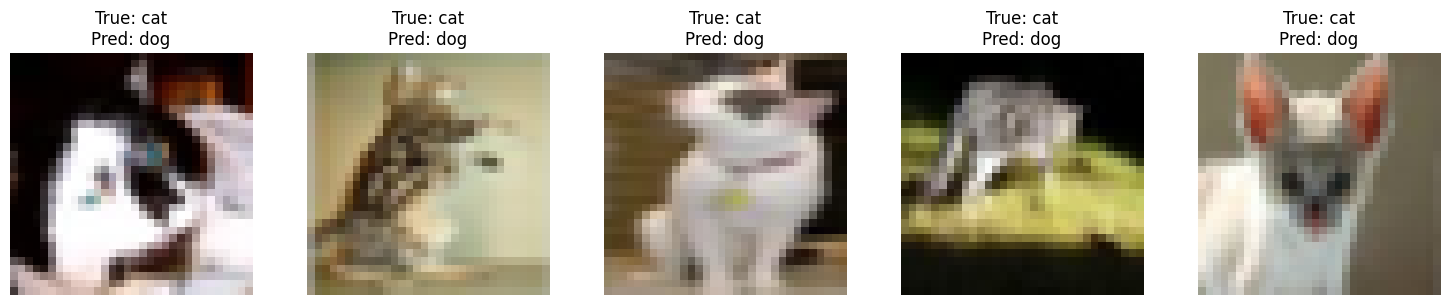

In [38]:
def visualize_predicted_dogs_true_cats(model, testloader, num_images=5):
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # Model evaluation mode
    model.eval()
    
    # Collect incorrect predictions
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            mask = (predicted == classes.index("dog")) & (labels == classes.index("cat"))
            incorrect_images.extend(images[mask].cpu().numpy())
            incorrect_labels.extend(labels[mask].cpu().numpy())
            incorrect_predictions.extend(predicted[mask].cpu().numpy())
    
    # Randomly select some images
    random_indices = random.sample(range(len(incorrect_images)), min(num_images, len(incorrect_images)))
    
    # Plot the images
    fig, axs = plt.subplots(1, len(random_indices), figsize=(3 * len(random_indices), 3))
    for i, idx in enumerate(random_indices):
        image = incorrect_images[idx].transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        label = classes[incorrect_labels[idx]]
        prediction = classes[incorrect_predictions[idx]]
        axs[i].imshow(image * 0.5 + 0.5)  # Denormalize
        axs[i].set_title(f"True: {label}\nPred: {prediction}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize predictions where pred is "dog" and true label is "cat"
visualize_predicted_dogs_true_cats(model, testloader)

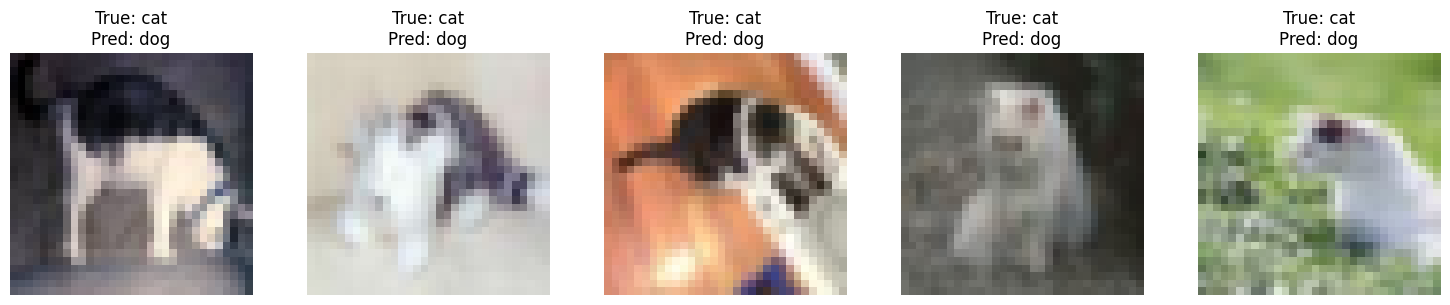

In [39]:
visualize_predicted_dogs_true_cats(model, testloader)

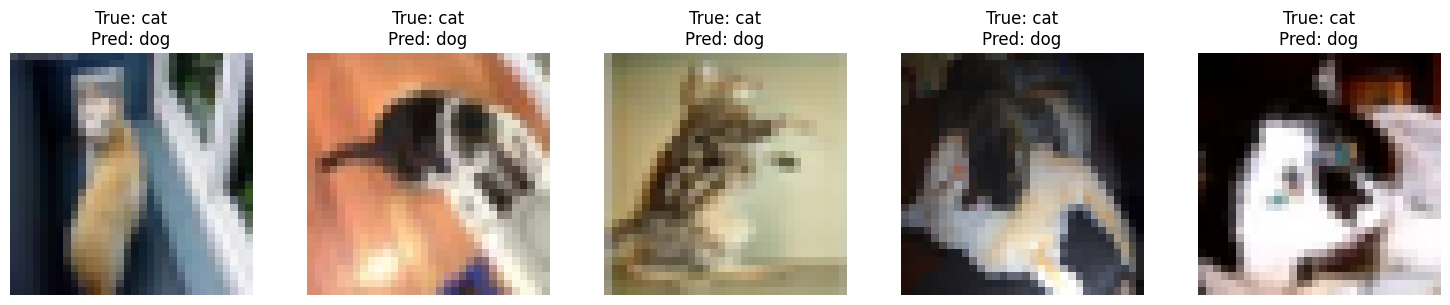

In [40]:
visualize_predicted_dogs_true_cats(model, testloader)

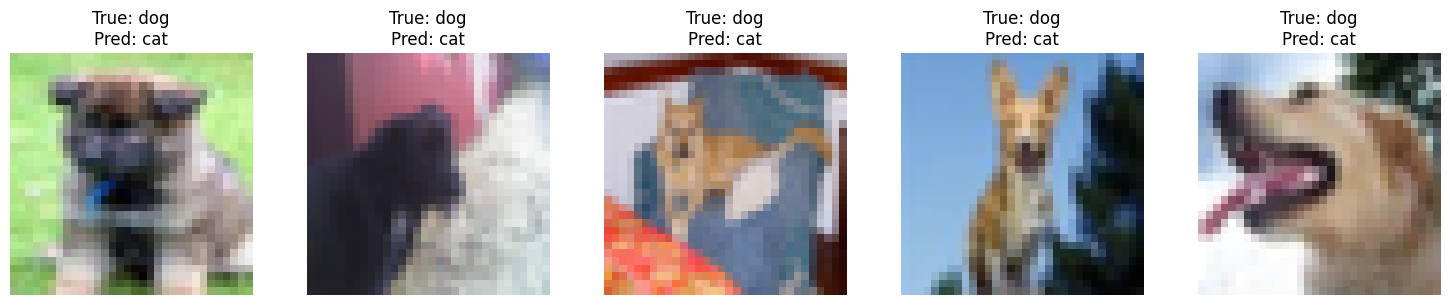

In [41]:
def visualize_predicted_cats_true_dogs(model, testloader, num_images=5):
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # Model evaluation mode
    model.eval()
    
    # Collect incorrect predictions
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            mask = (predicted == classes.index("cat")) & (labels == classes.index("dog"))
            incorrect_images.extend(images[mask].cpu().numpy())
            incorrect_labels.extend(labels[mask].cpu().numpy())
            incorrect_predictions.extend(predicted[mask].cpu().numpy())
    
    # Randomly select some images
    random_indices = random.sample(range(len(incorrect_images)), min(num_images, len(incorrect_images)))
    
    # Plot the images
    fig, axs = plt.subplots(1, len(random_indices), figsize=(3 * len(random_indices), 3))
    for i, idx in enumerate(random_indices):
        image = incorrect_images[idx].transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        label = classes[incorrect_labels[idx]]
        prediction = classes[incorrect_predictions[idx]]
        axs[i].imshow(image * 0.5 + 0.5)  # Denormalize
        axs[i].set_title(f"True: {label}\nPred: {prediction}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize predictions where pred is "cat" and true label is "dog"
visualize_predicted_cats_true_dogs(model, testloader)

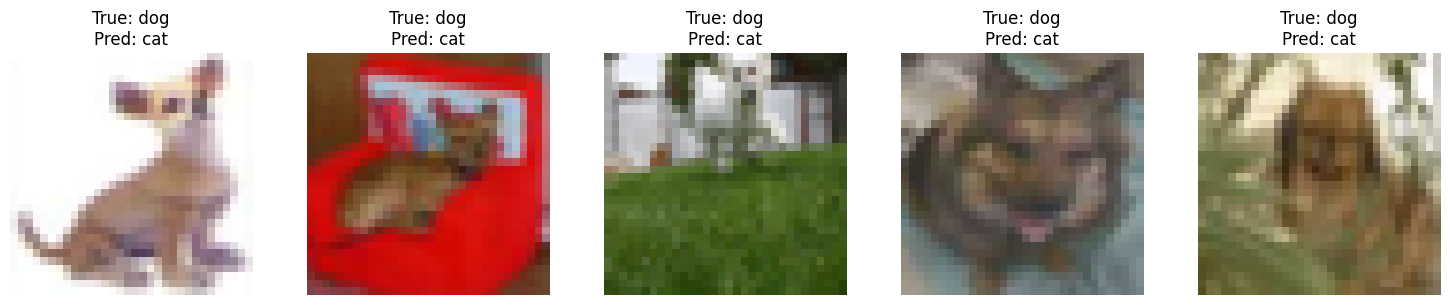

In [42]:
visualize_predicted_cats_true_dogs(model, testloader)

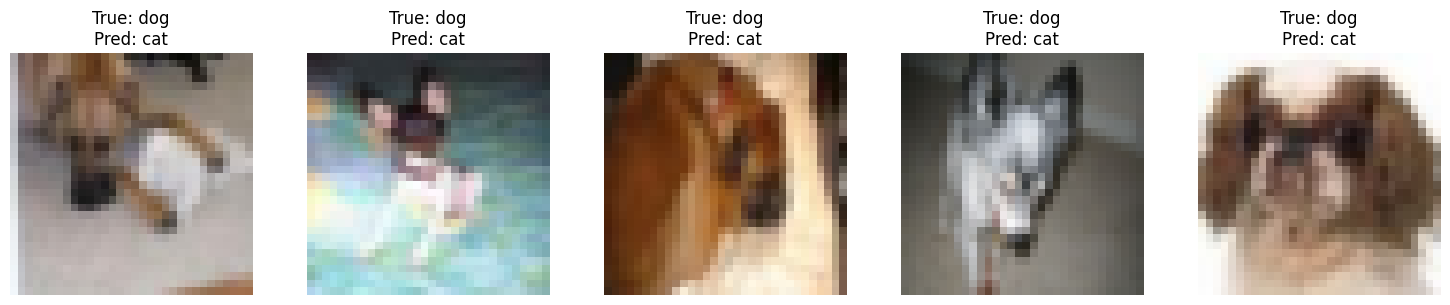

In [43]:
visualize_predicted_cats_true_dogs(model, testloader)

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [50]:
# 모델 불러오기
    # Initialize the model first (replace YourModelArchitecture with your model's class)
loaded_model = SimpleNet()
    
    # Load the state_dict into the model
loaded_model.load_state_dict(torch.load('DLthonsimplenet.pth'))
    
    # Move model to device
loaded_model = loaded_model.to(device)

all_targets = []
all_predictions = []

with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# 메트릭 계산
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)  # 클래스별 정밀도
recall = recall_score(all_targets, all_predictions, average=None)  # 클래스별 재현율
f1 = f1_score(all_targets, all_predictions, average=None)  # 클래스별 F1-점수

# 결과 출력
print(f"Accuracy: {accuracy}")
print(f"Class-wise Precision: {precision}")
print(f"Class-wise Recall: {recall}")
print(f"Class-wise F1 Score: {f1}")

Accuracy: 0.8164
Class-wise Precision: [0.91116751 0.95090715 0.70664207 0.72510373 0.6636971  0.824
 0.81051677 0.89101124 0.89835729 0.87957611]
Class-wise Recall: [0.718 0.891 0.766 0.699 0.894 0.721 0.894 0.793 0.875 0.913]
Class-wise F1 Score: [0.80313199 0.91997935 0.73512476 0.71181263 0.7618236  0.76906667
 0.85021398 0.83915344 0.88652482 0.89597645]


- Accuracy : 81.64 %
- 가장 높은 precision은 2번째 automobile이고 가장 낮은 precision 은 5번째 클래스 deer로 보임
- 가장 높은 recall은 10번째 truck이고 가장 낮은 recall은 4번째 cat 이 나왔다.
- F1 score 는 automobile이 가장 높았고 4번 cat이 가장 낮았다. 많다.)

In [51]:
correct = 0
total_cnt = 0

with torch.no_grad():
    for batch in testloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        logits = loaded_model(inputs)
        _, predictions = logits.max(1)
        
        # 'cat'과 'dog'를 제외한 데이터만 고려
        selected_indices = (targets != 3) & (targets != 5)
        
        correct += predictions[selected_indices].eq(targets[selected_indices]).sum().item()
        total_cnt += selected_indices.sum().item()

# Accuracy 계산
accuracy_without_cat_dog = correct / total_cnt

print(f"Accuracy (without 'cat' and 'dog'): {accuracy_without_cat_dog}")

Accuracy (without 'cat' and 'dog'): 0.846625
